In [1]:
import itertools
import networkx as nx
from networkx.generators.atlas import *
import matplotlib.pyplot as plt
import random
from networkx.drawing.nx_agraph import graphviz_layout
import networkx.algorithms.isomorphism as iso

import warnings
warnings.simplefilter("ignore")

## small graph inventory

1. get all non-isomorphic small graphs (`|V| < k`)
1. assign all theshold combinations to these small graphs
1. see which threshold combinations lead to a cascade saturating
1. take the threshold assginments that lead to a cascade and see which ones are isomorphic (with the attribute)


In [2]:
atlas = graph_atlas_g()
# all graphs up to size 4
small_graphs = [x for x in atlas if x.number_of_nodes() <= 4]

def accept_graph(graph, accepted_graphs):
    if nx.number_of_edges(graph) == 0:
        return False
    if nx.number_connected_components(graph) != 1:
        return False
    for a_graph in accepted_graphs:
        if nx.is_isomorphic(graph, a_graph):
            return False
    return True
        

# get only single-connected-component graphs
accepted_graphs = []
for graph in small_graphs:
    if accept_graph(graph, accepted_graphs):
        accepted_graphs.append(graph)

A = nx.Graph()
for graph in accepted_graphs:
    A = nx.disjoint_union(A, graph)

In [31]:
plt.figure(1,figsize=(8,8))
# layout graphs with positions using graphviz neato
pos=graphviz_layout(A, prog="neato")
# color nodes the same in each connected subgraph
C=nx.connected_component_subgraphs(A)
for g in C:
    c=[random.random()]*nx.number_of_nodes(g) # random color...
    nx.draw(
        g,
        pos,
        node_size=40,
        node_color=c,
        vmin=0.0,
        vmax=1.0,
        with_labels=False
    )
plt.show()

AttributeError: 'list' object has no attribute 'is_directed'

## space

set of all small graphs `a in A`, each graph having `|a|` nodes

the set of thresholds `t_|a| in T` where `|a|` is the number of nodes in `a` and where `t_|a|` is given by `(0 ... |a|-1)^|a|`

## algorithm

    initialize set of all small graphs A
    initialize empty list of isomorphic graphs S

    for each a in A
        get number of nodes |a|
        for each threshold vector t in (0, ..., |a| - 1)^|a|
            set g as graph a with thresholds t
            for s in S
                if g not isormophic with any s
                    add g to S
    
    

In [21]:
atlas = graph_atlas_g()
# all graphs up to size 4
A = [x for x in atlas if x.number_of_nodes() <= 4]

S = []

nm = iso.categorical_node_match('th', -1)

for a in A:
    n_a = len(a)
    for t in itertools.product(range(n_a), repeat=n_a):
        g = a.copy()
        for idx, th in enumerate(t):
            g.node[idx]['th'] = th
            g.node[idx]['active'] = False
        for s in S:
            if nx.is_isomorphic(g, s, node_match=nm):
                break
        else:
            S.append(g)

In [22]:
def does_saturate(graph):
    n = graph.number_of_nodes()
    inactive_node_set = set(graph.node.keys())
    checked_no_activation_node_set = set()
    while True:
        if len(inactive_node_set) == 0:
            return True
        if len(inactive_node_set) == len(checked_no_activation_node_set):
            # If there are 3 inactive nodes and we have checked all,
            # since last activation, checking again will not help
            return False
        to_check = random.sample(inactive_node_set, 1)[0]
        nbrs = graph.neighbors(to_check)
        th = graph.node[to_check]['th']
        active_nbrs = sum([graph.node[x]['active'] for x in nbrs])
        if active_nbrs >= th:
            graph.node[to_check]['active'] = True
            inactive_node_set -= set([to_check])
            checked_no_activation_node_set = set()
        else:
            checked_no_activation_node_set.add(to_check)

accepted_graphs = []
            
for s in S:
    if does_saturate(s):
        accepted_graphs.append(s)

In [23]:
print(len(S))
print(len(accepted_graphs))

1060
138


# simulate diffusion

for simplicity we assume that 0-activated nodes are correctly measured

this is a **conservative** assumption on our ability to measure

In [24]:
def correctly_measured(attr):
    # none - int -> False
    # 0 - none -> True
    # (int > 0) - none -> False
    # int - int != 1 -> False
    # int - int == 1 -> True
    prev = attr['prev']
    act = attr['act']
    if act == 0:
        return 1
    if prev == None:
        return 0
    if act - prev != 1:
        return 0
    return 1

def check_measurement(graph):
    # returns (correct, total)
    measured = {}
    for idx, attr in graph.nodes_iter(data=True):
        measured[idx] = correctly_measured(attr)
    return sum(measured.values()), len(graph)

def measurement_status(graph):
    n = graph.number_of_nodes()
    inactive_node_set = set(graph.node.keys())
    checked_no_activation_node_set = set()
    for idx in range(n):
        graph.node[idx]['active'] = False
        graph.node[idx]['prev'] = None
        graph.node[idx]['act'] = None    
    while True:
        if len(inactive_node_set) == 0:
            return check_measurement(graph)
        to_check = random.sample(inactive_node_set, 1)[0]
        nbrs = graph.neighbors(to_check)
        th = graph.node[to_check]['th']
        active_nbrs = sum([graph.node[x]['active'] for x in nbrs])
        if active_nbrs >= th:
            graph.node[to_check]['active'] = True
            graph.node[to_check]['act'] = active_nbrs
            inactive_node_set -= set([to_check])
            checked_no_activation_node_set = set()
        else:
            graph.node[to_check]['prev'] = active_nbrs
            checked_no_activation_node_set.add(to_check)

for graph in accepted_graphs:
    graph.graph['correct'] = 0
    graph.graph['total'] = 0
    
    for _ in range(100):
        correct, total = measurement_status(graph)
        graph.graph['correct'] += correct
        graph.graph['total'] += total

## plots

1. select all triads
1. order by atlas ordering and then threshold assignment

In [28]:
# order is num nodes
# size is num edges

all_dyads = [
    x for x in accepted_graphs if x.order() == 2 and x.size() == 1
]
triads_two_edge = [
    x for x in accepted_graphs if x.order() == 3 and x.size() == 2 
]
triads_three_edge = [
    x for x in accepted_graphs if x.size() == 3 and x.order() == 3
]
tetrad_three_edge = [
    x for x in accepted_graphs if x.size() == 3 and x.order() == 4
]
tetrad_four_edge = [
    x for x in accepted_graphs if x.size() == 4 and x.order() == 4
]
tetrad_five_edge = [
    x for x in accepted_graphs if x.size() == 5 and x.order() == 4
]
tetrad_six_edge = [
    x for x in accepted_graphs if x.size() == 6 and x.order() == 4
]

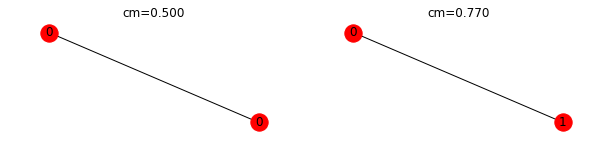

In [39]:
region = [1, len(all_dyads), 0]

plt.figure(1,figsize=(10,2))

for graph in all_dyads:
    pos=graphviz_layout(graph)
    region[2] += 1
    plt.subplot(*region)
    frac = graph.graph['correct'] / graph.graph['total']
    labs = {x: graph.node[x]['th'] for x in range(graph.number_of_nodes())}
    plt.title("cm={0:.3f}".format(frac))
    nx.draw(graph, pos, labels=labs)
plt.show()

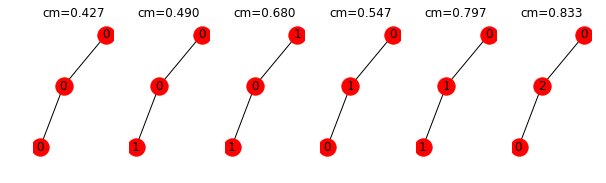

In [33]:
region = [1, len(triads_two_edge), 0]

plt.figure(1,figsize=(10,2.5))

for graph in triads_two_edge:
    pos=graphviz_layout(graph)
    region[2] += 1
    plt.subplot(*region)
    frac = graph.graph['correct'] / graph.graph['total']
    labs = {x: graph.node[x]['th'] for x in range(graph.number_of_nodes())}
    plt.title("cm={0:.3f}".format(frac))
    nx.draw(graph, pos, labels=labs)
plt.show()

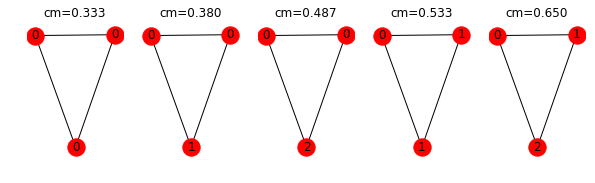

In [34]:
region = [1, len(triads_three_edge), 0]

plt.figure(1,figsize=(10,2.5))

for graph in triads_three_edge:
    pos=graphviz_layout(graph)
    region[2] += 1
    plt.subplot(*region)
    frac = graph.graph['correct'] / graph.graph['total']
    labs = {x: graph.node[x]['th'] for x in range(graph.number_of_nodes())}
    plt.title("cm={0:.3f}".format(frac))
    nx.draw(graph, pos, labels=labs)
plt.show()

In [35]:
region = [2, len(tetrad_three_edge) / 2, 0]

plt.figure(1,figsize=(14,5))

for graph in tetrad_three_edge:
    pos=graphviz_layout(graph)
    region[2] += 1
    plt.subplot(*region)
    frac = graph.graph['correct'] / graph.graph['total']
    labs = {x: graph.node[x]['th'] for x in range(graph.number_of_nodes())}
    plt.title("cm={0:.3f}".format(frac))
    nx.draw(graph, pos, labels=labs)
plt.show()

ValueError: num must be 1 <= num <= 26, not 27

In [27]:
all_dyads

## Plot measurement rate vs mean pairwise threshold difference

## Plot measurement rate vs difference between node degree and node threshold

## Which graphs + thresholds will *always* produce at least 1 mismeasurement?

## Enumerate all specific update orderings

# Rewrite

We have a set of graphs, which we can label with thresholds and update orderings